We will be solving the intruder detection problem analyzing his behavior on the Internet. It is a complicated and interesting problem combining the data analysis and behavioral psychology.

For example: Yandex solves the mailbox intruder detection problem based on the user's behavior patterns. In a nutshell, intruder's behaviour pattern might differ from the owner's one: 
- the breaker might not delete emails right after they are read, as the mailbox owner might do
- the intruder might mark emails and even move the cursor differently
- etc.

So the intruder could be detected and thrown out from the mailbox proposing the owner to be authentificated via SMS-code.
This pilot project is described in the Habrahabr article.

Similar things are being developed in Google Analytics and described in scientific researches. You can find more on this topic by searching "Traversal Pattern Mining" and "Sequential Pattern Mining".

In this competition we are going to solve a similar problem: our algorithm is supposed to analyze the sequence of websites consequently visited by a particular person and to predict whether this person is Alice or an intruder (someone else). As a metric we will use [ROC AUC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic). We will reveal who Alice is at the end of the course.

In [0]:
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

###  Data Downloading and Transformation

In [0]:
# G colab
!mkdir ../input
!wget -c http://romanr.info/tmp/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2.zip
!unzip -d ../input -o catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2.zip

--2020-02-12 14:27:04--  http://romanr.info/tmp/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2.zip
Resolving romanr.info (romanr.info)... 85.143.222.80, 2a04:ac00:1:52f1:5054:ff:fe00:6cc1
Connecting to romanr.info (romanr.info)|85.143.222.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26743371 (26M) [application/zip]
Saving to: ‘catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2.zip’

catch-me-if-you-can 100%[===================>]  25.50M  4.58MB/s    in 5.7s    

2020-02-12 14:27:11 (4.44 MB/s) - ‘catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2.zip’ saved [26743371/26743371]

Archive:  catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2.zip
  inflating: ../input/sample_submission.csv  
  inflating: ../input/site_dic.pkl   
  inflating: ../input/test_sessions.csv  
  inflating: ../input/train.zip      
  inflating: ../input/train_sessions.csv  


In [0]:
!ls -l ../input/

total 92288
-rw-r--r-- 1 root root  1230867 Nov 28 13:13 sample_submission.csv
-rw-r--r-- 1 root root  1800682 Nov 28 13:13 site_dic.pkl
-rw-r--r-- 1 root root 19450729 Nov 28 13:13 test_sessions.csv
-rw-r--r-- 1 root root 60526801 Nov 28 13:14 train_sessions.csv
-rw-r--r-- 1 root root 11483103 Nov 28 13:13 train.zip


In [0]:
!head ../input/train_sessions.csv

session_id,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
1,718,2014-02-20 10:02:45,,,,,,,,,,,,,,,,,,,0
2,890,2014-02-22 11:19:50,941,2014-02-22 11:19:50,3847,2014-02-22 11:19:51,941,2014-02-22 11:19:51,942,2014-02-22 11:19:51,3846,2014-02-22 11:19:51,3847,2014-02-22 11:19:52,3846,2014-02-22 11:19:52,1516,2014-02-22 11:20:15,1518,2014-02-22 11:20:16,0
3,14769,2013-12-16 16:40:17,39,2013-12-16 16:40:18,14768,2013-12-16 16:40:19,14769,2013-12-16 16:40:19,37,2013-12-16 16:40:19,39,2013-12-16 16:40:19,14768,2013-12-16 16:40:20,14768,2013-12-16 16:40:21,14768,2013-12-16 16:40:22,14768,2013-12-16 16:40:24,0
4,782,2014-03-28 10:52:12,782,2014-03-28 10:52:42,782,2014-03-28 10:53:12,782,2014-03-28 10:53:42,782,2014-03-28 10:54:12,782,2014-03-28 10:54:42,782,2014-03-28 10:55:12,782,2014-03-28 10:55:42,782,2014-03-28 10:56:12,782,2014-03-28 10:56:42,0
5,22,2014-02-28 10:53:05,177,2014-02-28 10:55:22,175,2014-02-28 1

First, read the training and test sets.

In [0]:
# Read the training and test data sets
train_df = pd.read_csv('../input/train_sessions.csv',
                       index_col='session_id', parse_dates=['time1'])
test_df = pd.read_csv('../input/test_sessions.csv',
                      index_col='session_id', parse_dates=['time1'])

In [0]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 253561 entries, 1 to 253561
Data columns (total 21 columns):
site1     253561 non-null int64
time1     253561 non-null datetime64[ns]
site2     250098 non-null float64
time2     250098 non-null object
site3     246919 non-null float64
time3     246919 non-null object
site4     244321 non-null float64
time4     244321 non-null object
site5     241829 non-null float64
time5     241829 non-null object
site6     239495 non-null float64
time6     239495 non-null object
site7     237297 non-null float64
time7     237297 non-null object
site8     235224 non-null float64
time8     235224 non-null object
site9     233084 non-null float64
time9     233084 non-null object
site10    231052 non-null float64
time10    231052 non-null object
target    253561 non-null int64
dtypes: datetime64[ns](1), float64(9), int64(2), object(9)
memory usage: 42.6+ MB


In [0]:
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
1,718,2014-02-20 10:02:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,2014-02-22 11:19:51,3846.0,2014-02-22 11:19:51,3847.0,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16,0
3,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,2013-12-16 16:40:19,39.0,2013-12-16 16:40:19,14768.0,2013-12-16 16:40:20,14768.0,2013-12-16 16:40:21,14768.0,2013-12-16 16:40:22,14768.0,2013-12-16 16:40:24,0
4,782,2014-03-28 10:52:12,782.0,2014-03-28 10:52:42,782.0,2014-03-28 10:53:12,782.0,2014-03-28 10:53:42,782.0,2014-03-28 10:54:12,782.0,2014-03-28 10:54:42,782.0,2014-03-28 10:55:12,782.0,2014-03-28 10:55:42,782.0,2014-03-28 10:56:12,782.0,2014-03-28 10:56:42,0
5,22,2014-02-28 10:53:05,177.0,2014-02-28 10:55:22,175.0,2014-02-28 10:55:22,178.0,2014-02-28 10:55:23,177.0,2014-02-28 10:55:23,178.0,2014-02-28 10:55:59,175.0,2014-02-28 10:55:59,177.0,2014-02-28 10:55:59,177.0,2014-02-28 10:57:06,178.0,2014-02-28 10:57:11,0


In [0]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82797 entries, 1 to 82797
Data columns (total 20 columns):
site1     82797 non-null int64
time1     82797 non-null datetime64[ns]
site2     81308 non-null float64
time2     81308 non-null object
site3     80075 non-null float64
time3     80075 non-null object
site4     79182 non-null float64
time4     79182 non-null object
site5     78341 non-null float64
time5     78341 non-null object
site6     77566 non-null float64
time6     77566 non-null object
site7     76840 non-null float64
time7     76840 non-null object
site8     76151 non-null float64
time8     76151 non-null object
site9     75484 non-null float64
time9     75484 non-null object
site10    74806 non-null float64
time10    74806 non-null object
dtypes: datetime64[ns](1), float64(9), int64(1), object(9)
memory usage: 13.3+ MB


In [0]:
test_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10
session_id,,,,,,,,,,,,,,,,,,,,
1,29,2014-10-04 11:19:53,35.0,2014-10-04 11:19:53,22.0,2014-10-04 11:19:54,321.0,2014-10-04 11:19:54,23.0,2014-10-04 11:19:54,2211.0,2014-10-04 11:19:54,6730.0,2014-10-04 11:19:54,21.0,2014-10-04 11:19:54,44582.0,2014-10-04 11:20:00,15336.0,2014-10-04 11:20:00
2,782,2014-07-03 11:00:28,782.0,2014-07-03 11:00:53,782.0,2014-07-03 11:00:58,782.0,2014-07-03 11:01:06,782.0,2014-07-03 11:01:09,782.0,2014-07-03 11:01:10,782.0,2014-07-03 11:01:23,782.0,2014-07-03 11:01:29,782.0,2014-07-03 11:01:30,782.0,2014-07-03 11:01:53
3,55,2014-12-05 15:55:12,55.0,2014-12-05 15:55:13,55.0,2014-12-05 15:55:14,55.0,2014-12-05 15:56:15,55.0,2014-12-05 15:56:16,55.0,2014-12-05 15:56:17,55.0,2014-12-05 15:56:18,55.0,2014-12-05 15:56:19,1445.0,2014-12-05 15:56:33,1445.0,2014-12-05 15:56:36
4,1023,2014-11-04 10:03:19,1022.0,2014-11-04 10:03:19,50.0,2014-11-04 10:03:20,222.0,2014-11-04 10:03:21,202.0,2014-11-04 10:03:21,3374.0,2014-11-04 10:03:22,50.0,2014-11-04 10:03:22,48.0,2014-11-04 10:03:22,48.0,2014-11-04 10:03:23,3374.0,2014-11-04 10:03:23
5,301,2014-05-16 15:05:31,301.0,2014-05-16 15:05:32,301.0,2014-05-16 15:05:33,66.0,2014-05-16 15:05:39,67.0,2014-05-16 15:05:40,69.0,2014-05-16 15:05:40,70.0,2014-05-16 15:05:40,68.0,2014-05-16 15:05:40,71.0,2014-05-16 15:05:40,167.0,2014-05-16 15:05:44


In [0]:
train_df.shape, test_df.shape

((253561, 21), (82797, 20))

The training data set contains the following features:

- **site1** – id of the first visited website in the session
- **time1** – visiting time for the first website in the session
- ...
- **site10** – id of the tenth visited website in the session
- **time10** – visiting time for the tenth website in the session
- **target** – target variable, possesses value of 1 for Alice's sessions, and 0 for the other users' sessions
    
User sessions are chosen in the way they are not longer than half an hour or/and contain more than ten websites. I.e. a session is considered as ended either if a user has visited ten websites or if a session has lasted over thirty minutes.

### Merge all data into single table

In [0]:
test_df['target'] = -1
test_df.shape

(82797, 21)

In [0]:
df = pd.concat([train_df, test_df])
df.shape

(336358, 21)

# Data scructure analysis

NaNs:

In [0]:
for p in ('site', 'time'):
  for i in range(1,11):
    n = p + str(i)
    print(n + ': ', df[pd.isna(df[n])].shape[0])

site1:  0
site2:  4952
site3:  9364
site4:  12855
site5:  16188
site6:  19297
site7:  22221
site8:  24983
site9:  27790
site10:  30500
time1:  0
time2:  4952
time3:  9364
time4:  12855
time5:  16188
time6:  19297
time7:  22221
time8:  24983
time9:  27790
time10:  30500


Zeros:

In [0]:
for i in range(1,11):
  n = 'site' + str(i)
  print(n + ': ', df[df[n] == 0].shape[0])

site1:  0
site2:  0
site3:  0
site4:  0
site5:  0
site6:  0
site7:  0
site8:  0
site9:  0
site10:  0


# Coding of missing data
- Using `-1` as undefined data, since `0` is a valid value for datetime parts (dayofweek, hour, min, etc).

In [0]:
df.fillna(-1, inplace=True)
for p in ('site', 'time'):
  for i in range(1,11):
    n = p + str(i)
    print(n + ': ', df[pd.isna(df[n])].shape[0])

site1:  0
site2:  0
site3:  0
site4:  0
site5:  0
site6:  0
site7:  0
site8:  0
site9:  0
site10:  0
time1:  0
time2:  0
time3:  0
time4:  0
time5:  0
time6:  0
time7:  0
time8:  0
time9:  0
time10:  0


floats:

In [0]:
for i in range(1,11):
  n = 'site' + str(i)
  print(n + ': ', df[df[n].astype(int) - df[n] > 0].shape[0])

site1:  0
site2:  0
site3:  0
site4:  0
site5:  0
site6:  0
site7:  0
site8:  0
site9:  0
site10:  0


In [0]:
for i in range(2,11):
  n = 'site' + str(i)
  df[n] = df[n].astype(int)

In [0]:
for i in range(2,11):
  n = 'time' + str(i)
  df[n] = df[n].astype('datetime64[ns]')

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 336358 entries, 1 to 82797
Data columns (total 21 columns):
site1     336358 non-null int64
time1     336358 non-null datetime64[ns]
site2     336358 non-null int64
time2     336358 non-null datetime64[ns]
site3     336358 non-null int64
time3     336358 non-null datetime64[ns]
site4     336358 non-null int64
time4     336358 non-null datetime64[ns]
site5     336358 non-null int64
time5     336358 non-null datetime64[ns]
site6     336358 non-null int64
time6     336358 non-null datetime64[ns]
site7     336358 non-null int64
time7     336358 non-null datetime64[ns]
site8     336358 non-null int64
time8     336358 non-null datetime64[ns]
site9     336358 non-null int64
time9     336358 non-null datetime64[ns]
site10    336358 non-null int64
time10    336358 non-null datetime64[ns]
target    336358 non-null int64
dtypes: datetime64[ns](10), int64(11)
memory usage: 56.5 MB


In [0]:
df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
1,718,2014-02-20 10:02:45,-1,1969-12-31 23:59:59.999999999,-1,1969-12-31 23:59:59.999999999,-1,1969-12-31 23:59:59.999999999,-1,1969-12-31 23:59:59.999999999,-1,1969-12-31 23:59:59.999999999,-1,1969-12-31 23:59:59.999999999,-1,1969-12-31 23:59:59.999999999,-1,1969-12-31 23:59:59.999999999,-1,1969-12-31 23:59:59.999999999,0
2,890,2014-02-22 11:19:50,941,2014-02-22 11:19:50.000000000,3847,2014-02-22 11:19:51.000000000,941,2014-02-22 11:19:51.000000000,942,2014-02-22 11:19:51.000000000,3846,2014-02-22 11:19:51.000000000,3847,2014-02-22 11:19:52.000000000,3846,2014-02-22 11:19:52.000000000,1516,2014-02-22 11:20:15.000000000,1518,2014-02-22 11:20:16.000000000,0
3,14769,2013-12-16 16:40:17,39,2013-12-16 16:40:18.000000000,14768,2013-12-16 16:40:19.000000000,14769,2013-12-16 16:40:19.000000000,37,2013-12-16 16:40:19.000000000,39,2013-12-16 16:40:19.000000000,14768,2013-12-16 16:40:20.000000000,14768,2013-12-16 16:40:21.000000000,14768,2013-12-16 16:40:22.000000000,14768,2013-12-16 16:40:24.000000000,0
4,782,2014-03-28 10:52:12,782,2014-03-28 10:52:42.000000000,782,2014-03-28 10:53:12.000000000,782,2014-03-28 10:53:42.000000000,782,2014-03-28 10:54:12.000000000,782,2014-03-28 10:54:42.000000000,782,2014-03-28 10:55:12.000000000,782,2014-03-28 10:55:42.000000000,782,2014-03-28 10:56:12.000000000,782,2014-03-28 10:56:42.000000000,0
5,22,2014-02-28 10:53:05,177,2014-02-28 10:55:22.000000000,175,2014-02-28 10:55:22.000000000,178,2014-02-28 10:55:23.000000000,177,2014-02-28 10:55:23.000000000,178,2014-02-28 10:55:59.000000000,175,2014-02-28 10:55:59.000000000,177,2014-02-28 10:55:59.000000000,177,2014-02-28 10:57:06.000000000,178,2014-02-28 10:57:11.000000000,0


# Target analysis

Dispersion:

(array([ 82797.,      0.,      0.,      0.,      0., 251264.,      0.,
             0.,      0.,   2297.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

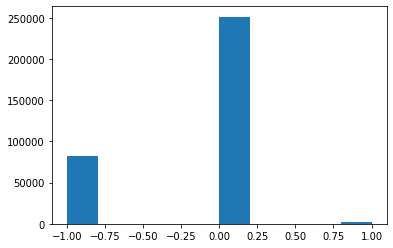

In [0]:
plt.hist(df['target'])

Time dependency:

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


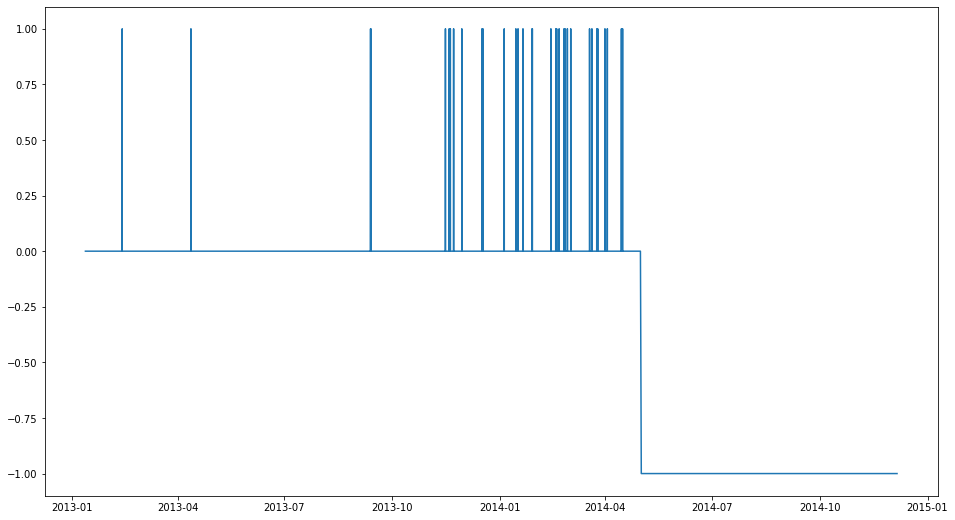

In [0]:
df.sort_values('time1', inplace=True)
plt.figure(figsize=(16, 9))
plt.plot(df.time1, df.target)

`dur` columns:

In [0]:
for i,k in [(x,x+1) for x in range(1,10)]:
  df['dur' + str(i)] = (df['time' + str(k)] - df['time' + str(i)]).astype('timedelta64[s]').astype('int') + 1
  df.loc[df['time' + str(k)].astype('int') == -1, 'dur' + str(i)] = -1
df[['dur' + str(i) for i in range(1,10)]].head()

,dur1,dur2,dur3,dur4,dur5,dur6,dur7,dur8,dur9
session_id,,,,,,,,,
21669,1,-1,-1,-1,-1,-1,-1,-1,-1
54843,1,1785,3,-1,-1,-1,-1,-1,-1
77292,2,2,1,2,1,1,1,2,1
114021,1,2,1,1,1,2,1,1,2
146670,1,1,2,1,1,1,2,1,1


In [0]:
tmp = df[['dur' + str(i) for i in range(1,10)]].copy()
tmp.head()

,dur1,dur2,dur3,dur4,dur5,dur6,dur7,dur8,dur9
session_id,,,,,,,,,
21669,1,-1,-1,-1,-1,-1,-1,-1,-1
54843,1,1785,3,-1,-1,-1,-1,-1,-1
77292,2,2,1,2,1,1,1,2,1
114021,1,2,1,1,1,2,1,1,2
146670,1,1,2,1,1,1,2,1,1


In [0]:
for i in range(1,10):
  tmp.loc[tmp['dur' + str(i)] == -1, 'dur' + str(i)] = 0
tmp.head()

,dur1,dur2,dur3,dur4,dur5,dur6,dur7,dur8,dur9
session_id,,,,,,,,,
21669,1,0,0,0,0,0,0,0,0
54843,1,1785,3,0,0,0,0,0,0
77292,2,2,1,2,1,1,1,2,1
114021,1,2,1,1,1,2,1,1,2
146670,1,1,2,1,1,1,2,1,1


In [0]:
df['dur'] = tmp[['dur' + str(i) for i in range(1,10)]].sum(axis=1)
df[['dur' + str(i) for i in range(1,10)] + ['dur']].head()

,dur1,dur2,dur3,dur4,dur5,dur6,dur7,dur8,dur9,dur
session_id,,,,,,,,,,
21669,1,-1,-1,-1,-1,-1,-1,-1,-1,1
54843,1,1785,3,-1,-1,-1,-1,-1,-1,1789
77292,2,2,1,2,1,1,1,2,1,13
114021,1,2,1,1,1,2,1,1,2,12
146670,1,1,2,1,1,1,2,1,1,11


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 336358 entries, 21669 to 60141
Data columns (total 31 columns):
site1     336358 non-null int64
time1     336358 non-null datetime64[ns]
site2     336358 non-null int64
time2     336358 non-null datetime64[ns]
site3     336358 non-null int64
time3     336358 non-null datetime64[ns]
site4     336358 non-null int64
time4     336358 non-null datetime64[ns]
site5     336358 non-null int64
time5     336358 non-null datetime64[ns]
site6     336358 non-null int64
time6     336358 non-null datetime64[ns]
site7     336358 non-null int64
time7     336358 non-null datetime64[ns]
site8     336358 non-null int64
time8     336358 non-null datetime64[ns]
site9     336358 non-null int64
time9     336358 non-null datetime64[ns]
site10    336358 non-null int64
time10    336358 non-null datetime64[ns]
target    336358 non-null int64
dur1      336358 non-null int64
dur2      336358 non-null int64
dur3      336358 non-null int64
dur4      336358 non-null in

In [0]:
df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10,target,dur1,dur2,dur3,dur4,dur5,dur6,dur7,dur8,dur9,dur
session_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55,2013-01-12 08:05:57,-1,1969-12-31 23:59:59.999999999,-1,1969-12-31 23:59:59.999999999,-1,1969-12-31 23:59:59.999999999,-1,1969-12-31 23:59:59.999999999,-1,1969-12-31 23:59:59.999999999,-1,1969-12-31 23:59:59.999999999,-1,1969-12-31 23:59:59.999999999,-1,1969-12-31 23:59:59.999999999,0,1,-1,-1,-1,-1,-1,-1,-1,-1,1
54843,56,2013-01-12 08:37:23,55,2013-01-12 08:37:23,56,2013-01-12 09:07:07.000000000,55,2013-01-12 09:07:09.000000000,-1,1969-12-31 23:59:59.999999999,-1,1969-12-31 23:59:59.999999999,-1,1969-12-31 23:59:59.999999999,-1,1969-12-31 23:59:59.999999999,-1,1969-12-31 23:59:59.999999999,-1,1969-12-31 23:59:59.999999999,0,1,1785,3,-1,-1,-1,-1,-1,-1,1789
77292,946,2013-01-12 08:50:13,946,2013-01-12 08:50:14,951,2013-01-12 08:50:15.000000000,946,2013-01-12 08:50:15.000000000,946,2013-01-12 08:50:16.000000000,945,2013-01-12 08:50:16.000000000,948,2013-01-12 08:50:16.000000000,784,2013-01-12 08:50:16.000000000,949,2013-01-12 08:50:17.000000000,946,2013-01-12 08:50:17.000000000,0,2,2,1,2,1,1,1,2,1,13
114021,945,2013-01-12 08:50:17,948,2013-01-12 08:50:17,949,2013-01-12 08:50:18.000000000,948,2013-01-12 08:50:18.000000000,945,2013-01-12 08:50:18.000000000,946,2013-01-12 08:50:18.000000000,947,2013-01-12 08:50:19.000000000,945,2013-01-12 08:50:19.000000000,946,2013-01-12 08:50:19.000000000,946,2013-01-12 08:50:20.000000000,0,1,2,1,1,1,2,1,1,2,12
146670,947,2013-01-12 08:50:20,950,2013-01-12 08:50:20,948,2013-01-12 08:50:20.000000000,947,2013-01-12 08:50:21.000000000,950,2013-01-12 08:50:21.000000000,952,2013-01-12 08:50:21.000000000,946,2013-01-12 08:50:21.000000000,951,2013-01-12 08:50:22.000000000,946,2013-01-12 08:50:22.000000000,947,2013-01-12 08:50:22.000000000,0,1,1,2,1,1,1,2,1,1,11


In [0]:
df[df.dur == -1].shape

(0, 31)

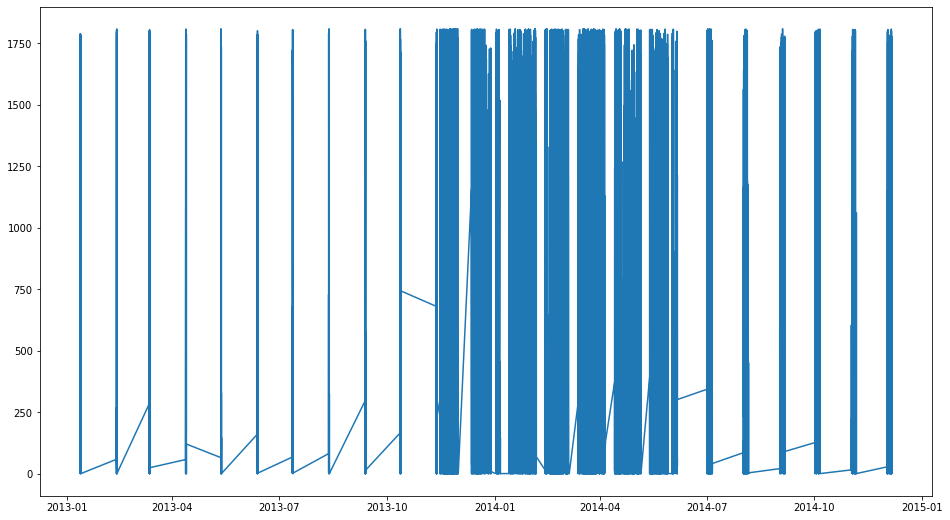

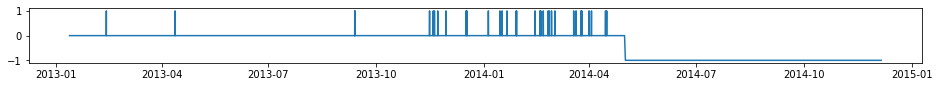

In [0]:
df.sort_values('time1', inplace=True)
plt.figure(figsize=(16,9))
plt.plot(df.time1, df.dur)
plt.show()
plt.figure(figsize=(16,1))
plt.plot(df.time1, df.target)
plt.show()

day, hour, min, mon, dom, week columns:

In [0]:
for i in range(1,11):
  df['dow' + str(i)] = df['time' + str(i)].dt.dayofweek
  df['hour' + str(i)] = df['time' + str(i)].dt.hour
  df['min' + str(i)] = df['time' + str(i)].dt.minute
  df['mon' + str(i)] = df['time' + str(i)].dt.month
  df['dom' + str(i)] = df['time' + str(i)].dt.day
  df['week' + str(i)] = df['time' + str(i)].dt.week
  df.loc[df['time' + str(i)].astype('int') == -1, [x + str(i) for x in ('dow', 'hour', 'min', 'mon', 'dom', 'week')]] = -1
df[[x + str(i) for i in range(1,11) for x in ('time', 'dow', 'hour', 'min', 'mon', 'dom', 'week')]].head()

,time1,dow1,hour1,min1,mon1,dom1,week1,time2,dow2,hour2,min2,mon2,dom2,week2,time3,dow3,hour3,min3,mon3,dom3,week3,time4,dow4,hour4,min4,mon4,dom4,week4,time5,dow5,hour5,min5,mon5,dom5,week5,time6,dow6,hour6,min6,mon6,dom6,week6,time7,dow7,hour7,min7,mon7,dom7,week7,time8,dow8,hour8,min8,mon8,dom8,week8,time9,dow9,hour9,min9,mon9,dom9,week9,time10,dow10,hour10,min10,mon10,dom10,week10
session_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
21669,2013-01-12 08:05:57,5,8,5,1,12,2,2013-01-12 08:05:57,5,8,5,1,12,2,1969-12-31 23:59:59.999999999,-1,-1,-1,-1,-1,-1,1969-12-31 23:59:59.999999999,-1,-1,-1,-1,-1,-1,1969-12-31 23:59:59.999999999,-1,-1,-1,-1,-1,-1,1969-12-31 23:59:59.999999999,-1,-1,-1,-1,-1,-1,1969-12-31 23:59:59.999999999,-1,-1,-1,-1,-1,-1,1969-12-31 23:59:59.999999999,-1,-1,-1,-1,-1,-1,1969-12-31 23:59:59.999999999,-1,-1,-1,-1,-1,-1,1969-12-31 23:59:59.999999999,-1,-1,-1,-1,-1,-1
54843,2013-01-12 08:37:23,5,8,37,1,12,2,2013-01-12 08:37:23,5,8,37,1,12,2,2013-01-12 09:07:07.000000000,5,9,7,1,12,2,2013-01-12 09:07:09.000000000,5,9,7,1,12,2,1969-12-31 23:59:59.999999999,-1,-1,-1,-1,-1,-1,1969-12-31 23:59:59.999999999,-1,-1,-1,-1,-1,-1,1969-12-31 23:59:59.999999999,-1,-1,-1,-1,-1,-1,1969-12-31 23:59:59.999999999,-1,-1,-1,-1,-1,-1,1969-12-31 23:59:59.999999999,-1,-1,-1,-1,-1,-1,1969-12-31 23:59:59.999999999,-1,-1,-1,-1,-1,-1
77292,2013-01-12 08:50:13,5,8,50,1,12,2,2013-01-12 08:50:14,5,8,50,1,12,2,2013-01-12 08:50:15.000000000,5,8,50,1,12,2,2013-01-12 08:50:15.000000000,5,8,50,1,12,2,2013-01-12 08:50:16.000000000,5,8,50,1,12,2,2013-01-12 08:50:16.000000000,5,8,50,1,12,2,2013-01-12 08:50:16.000000000,5,8,50,1,12,2,2013-01-12 08:50:16.000000000,5,8,50,1,12,2,2013-01-12 08:50:17.000000000,5,8,50,1,12,2,2013-01-12 08:50:17.000000000,5,8,50,1,12,2
114021,2013-01-12 08:50:17,5,8,50,1,12,2,2013-01-12 08:50:17,5,8,50,1,12,2,2013-01-12 08:50:18.000000000,5,8,50,1,12,2,2013-01-12 08:50:18.000000000,5,8,50,1,12,2,2013-01-12 08:50:18.000000000,5,8,50,1,12,2,2013-01-12 08:50:18.000000000,5,8,50,1,12,2,2013-01-12 08:50:19.000000000,5,8,50,1,12,2,2013-01-12 08:50:19.000000000,5,8,50,1,12,2,2013-01-12 08:50:19.000000000,5,8,50,1,12,2,2013-01-12 08:50:20.000000000,5,8,50,1,12,2
146670,2013-01-12 08:50:20,5,8,50,1,12,2,2013-01-12 08:50:20,5,8,50,1,12,2,2013-01-12 08:50:20.000000000,5,8,50,1,12,2,2013-01-12 08:50:21.000000000,5,8,50,1,12,2,2013-01-12 08:50:21.000000000,5,8,50,1,12,2,2013-01-12 08:50:21.000000000,5,8,50,1,12,2,2013-01-12 08:50:21.000000000,5,8,50,1,12,2,2013-01-12 08:50:22.000000000,5,8,50,1,12,2,2013-01-12 08:50:22.000000000,5,8,50,1,12,2,2013-01-12 08:50:22.000000000,5,8,50,1,12,2


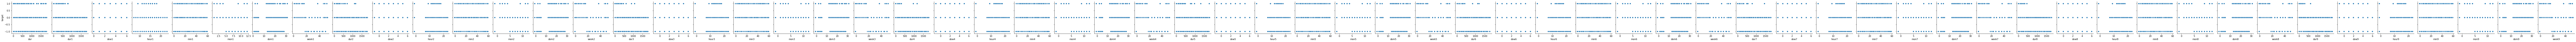

CPU times: user 2min 52s, sys: 6.89 s, total: 2min 59s
Wall time: 2min 51s


In [0]:
%%time
sns.pairplot(df, y_vars=['target'], x_vars=['dur']
             + [x + str(i) for i in range(1,10) for x in ('dur', 'dow', 'hour', 'min', 'mon', 'dom', 'week')]
             )
plt.show()

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 336358 entries, 21669 to 60141
Data columns (total 91 columns):
site1     336358 non-null int64
time1     336358 non-null datetime64[ns]
site2     336358 non-null int64
time2     336358 non-null datetime64[ns]
site3     336358 non-null int64
time3     336358 non-null datetime64[ns]
site4     336358 non-null int64
time4     336358 non-null datetime64[ns]
site5     336358 non-null int64
time5     336358 non-null datetime64[ns]
site6     336358 non-null int64
time6     336358 non-null datetime64[ns]
site7     336358 non-null int64
time7     336358 non-null datetime64[ns]
site8     336358 non-null int64
time8     336358 non-null datetime64[ns]
site9     336358 non-null int64
time9     336358 non-null datetime64[ns]
site10    336358 non-null int64
time10    336358 non-null datetime64[ns]
target    336358 non-null int64
dur1      336358 non-null int64
dur2      336358 non-null int64
dur3      336358 non-null int64
dur4      336358 non-null in

In [0]:
df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10,target,dur1,dur2,dur3,dur4,dur5,dur6,dur7,dur8,dur9,dur,dow1,hour1,min1,mon1,dom1,week1,dow2,hour2,min2,...,min4,mon4,dom4,week4,dow5,hour5,min5,mon5,dom5,week5,dow6,hour6,min6,mon6,dom6,week6,dow7,hour7,min7,mon7,dom7,week7,dow8,hour8,min8,mon8,dom8,week8,dow9,hour9,min9,mon9,dom9,week9,dow10,hour10,min10,mon10,dom10,week10
session_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55,2013-01-12 08:05:57,-1,1969-12-31 23:59:59.999999999,-1,1969-12-31 23:59:59.999999999,-1,1969-12-31 23:59:59.999999999,-1,1969-12-31 23:59:59.999999999,-1,1969-12-31 23:59:59.999999999,-1,1969-12-31 23:59:59.999999999,-1,1969-12-31 23:59:59.999999999,-1,1969-12-31 23:59:59.999999999,0,1,-1,-1,-1,-1,-1,-1,-1,-1,1,5,8,5,1,12,2,5,8,5,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
54843,56,2013-01-12 08:37:23,55,2013-01-12 08:37:23,56,2013-01-12 09:07:07.000000000,55,2013-01-12 09:07:09.000000000,-1,1969-12-31 23:59:59.999999999,-1,1969-12-31 23:59:59.999999999,-1,1969-12-31 23:59:59.999999999,-1,1969-12-31 23:59:59.999999999,-1,1969-12-31 23:59:59.999999999,-1,1969-12-31 23:59:59.999999999,0,1,1785,3,-1,-1,-1,-1,-1,-1,1789,5,8,37,1,12,2,5,8,37,...,7,1,12,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
77292,946,2013-01-12 08:50:13,946,2013-01-12 08:50:14,951,2013-01-12 08:50:15.000000000,946,2013-01-12 08:50:15.000000000,946,2013-01-12 08:50:16.000000000,945,2013-01-12 08:50:16.000000000,948,2013-01-12 08:50:16.000000000,784,2013-01-12 08:50:16.000000000,949,2013-01-12 08:50:17.000000000,946,2013-01-12 08:50:17.000000000,0,2,2,1,2,1,1,1,2,1,13,5,8,50,1,12,2,5,8,50,...,50,1,12,2,5,8,50,1,12,2,5,8,50,1,12,2,5,8,50,1,12,2,5,8,50,1,12,2,5,8,50,1,12,2,5,8,50,1,12,2
114021,945,2013-01-12 08:50:17,948,2013-01-12 08:50:17,949,2013-01-12 08:50:18.000000000,948,2013-01-12 08:50:18.000000000,945,2013-01-12 08:50:18.000000000,946,2013-01-12 08:50:18.000000000,947,2013-01-12 08:50:19.000000000,945,2013-01-12 08:50:19.000000000,946,2013-01-12 08:50:19.000000000,946,2013-01-12 08:50:20.000000000,0,1,2,1,1,1,2,1,1,2,12,5,8,50,1,12,2,5,8,50,...,50,1,12,2,5,8,50,1,12,2,5,8,50,1,12,2,5,8,50,1,12,2,5,8,50,1,12,2,5,8,50,1,12,2,5,8,50,1,12,2
146670,947,2013-01-12 08:50:20,950,2013-01-12 08:50:20,948,2013-01-12 08:50:20.000000000,947,2013-01-12 08:50:21.000000000,950,2013-01-12 08:50:21.000000000,952,2013-01-12 08:50:21.000000000,946,2013-01-12 08:50:21.000000000,951,2013-01-12 08:50:22.000000000,946,2013-01-12 08:50:22.000000000,947,2013-01-12 08:50:22.000000000,0,1,1,2,1,1,1,2,1,1,11,5,8,50,1,12,2,5,8,50,...,50,1,12,2,5,8,50,1,12,2,5,8,50,1,12,2,5,8,50,1,12,2,5,8,50,1,12,2,5,8,50,1,12,2,5,8,50,1,12,2
